# Project 4, Adem Kaya

In this week's project we are working with text data and getting with Natural Language Processing (NLP)

Aim:
- Choose two singers and extract thier lyricys

- Construct a machine llearning model that predicts singer. 


The training data is important:
- People most of the time remember the first few words of the song and probably do search with these words

- The repeat of the song is more likely to be remembered easily 





In [1]:
# Import necessary libraries

import requests
from bs4 import BeautifulSoup
import re
import csv
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download("wordnet")
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN



[nltk_data] Downloading package wordnet to /home/kaya/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/kaya/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# This line is added not to be balclisted

headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}

In [3]:
# We choose the groups Random-Chance and Random-Axe

# Get the url

main_url = 'https://www.lyrics.com'

artist_sublink_1 = '/artist/Random-Chance/2137861628' 
artist_sublink_2 = '/artist/Random-Axe/2124228'
url_1 = main_url + artist_sublink_1
url_2 = main_url + artist_sublink_2

In [4]:
response_1 = requests.get(url_1, headers=headers)
response_2 = requests.get(url_2, headers=headers)

In [5]:
response_1

<Response [200]>

In [6]:
response_2

<Response [200]>

In [7]:
response_1.status_code

200

In [8]:
response_2.status_code

200

The contents of the webpage are saved in the `.text` attribute.

In [9]:
lyrics_html_1 = response_1.text
lyrics_soup_1 = BeautifulSoup(lyrics_html_1,"html.parser")

lyrics_html_2 = response_2.text
lyrics_soup_2 = BeautifulSoup(lyrics_html_2,"html.parser")



 Extract the hyper links for all the songs

In [10]:
links_1 = lyrics_soup_1.find_all(class_="tal qx")

links_2 = lyrics_soup_2.find_all(class_="tal qx")



In [11]:
# get_hyper() function handles the duplication in the lists Links_1 and Links_2. 

def get_hyper(links):
    
    lyric_list = []

    # add all the links in 'lyric_list'
    for link in links:
        web_link = link.a['href']
        
        lyric_list.append(web_link)
        


    # create an emty list 
    duplicate = []

    
    
    # check duplications and add the indexes of duplications in 'duplicate'
    for i in range(0,len(lyric_list)-1):
       string_i = lyric_list[i][28:35]
      
       for j in range(i+1,len(lyric_list)-1):
           string_j = lyric_list[j][28:35]
          
           if string_i == string_j:
              
              duplicate.append(j)

    # Remove repetaed numbers            
    duplicate1 = list(set(duplicate))


    # craete a new empty list to save the duplicated links
    lyric_list_r = []

    for i in duplicate1:
      
       lyric_list_r.append(lyric_list[i])
                        

    # remove the duplicated links from the original list using index number        
    for k in lyric_list_r:
       
       lyric_list.remove(k)



    
    
    # sum up main link and the song related part
    lyric_list_href = []

    for i in lyric_list:
       song_url = main_url + i
       lyric_list_href.append(song_url)
       print(song_url)

    return  lyric_list_href

In [12]:
# take the first 6 songs from each group to construct the training data 

lyric_list_href_1_train = get_hyper(links_1)[0:6]

lyric_list_href_2_train = get_hyper(links_2)[0:6]

lyric_list_href_1_test = get_hyper(links_1)[6:7]

lyric_list_href_2_test = get_hyper(links_2)[6:7]



https://www.lyrics.com/lyric-lf/5635743/Random+Chance/LEGOS
https://www.lyrics.com/lyric-lf/5715201/Random+Chance/Normal+Life
https://www.lyrics.com/lyric-lf/6075911/Random+Chance/Circles
https://www.lyrics.com/lyric-lf/4714490/Random+Chance/Candy
https://www.lyrics.com/lyric-lf/5883284/Random+Chance/Okay
https://www.lyrics.com/lyric-lf/4522774/Random+Chance/Distance
https://www.lyrics.com/lyric-lf/6007658/Random+Chance/Hometown+Nowhere
https://www.lyrics.com/lyric-lf/7185218/Random+Chance/THINKING+ABOUT+U
https://www.lyrics.com/lyric/23534667/Random+Axe/Zoo+Drugs
https://www.lyrics.com/lyric/23534666/Random+Axe/Random+Call
https://www.lyrics.com/lyric/23534665/Random+Axe/Black+Ops
https://www.lyrics.com/lyric/23534664/Random+Axe/Chewbacca
https://www.lyrics.com/lyric/23534663/Random+Axe/The+Hex
https://www.lyrics.com/lyric/23534662/Random+Axe/Understand+This
https://www.lyrics.com/lyric/23534661/Random+Axe/Everybody+Nobody+Somebody
https://www.lyrics.com/lyric/23534659/Random+Axe/The+

In [13]:
# Extract the text for each song 'and' save im CORPUS_...

CORPUS_1_train = []
CORPUS_1_train_temp = []


for song_link in  lyric_list_href_1_train:
    url_1 = song_link
    
    response_1 = requests.get(url_1)

    spiced_soup_1 = BeautifulSoup(response_1.text)
    
    CORPUS_1_train_temp = []
    
    for title in spiced_soup_1.find_all(class_='lyric-body'):
        
        title_splited = re.split("\n",title.text)  
        
        for k in title_splited:
            if k != '':
                CORPUS_1_train_temp.append(k)
    # add the first two lines of the song    
    if len(CORPUS_1_train_temp) > 0:
        CORPUS_1_train.append(CORPUS_1_train_temp[0])   
        CORPUS_1_train.append(CORPUS_1_train_temp[1]) 
    
        # add repeated part, to do this choose the first 15 caharacters of the line
        for i in CORPUS_1_train_temp:
           s_i = i[0:12]
           for j in CORPUS_1_train_temp:
                s_j = j[0:12]
                if s_i==s_j:
                    CORPUS_1_train.append(i)   
    
#  remove duplicates     

CORPUS_1_train = list(set(CORPUS_1_train))





CORPUS_2_train = []
CORPUS_2_train_temp = []


for song_link in  lyric_list_href_2_train:
    url_1 = song_link
    
    response_1 = requests.get(url_1)

    spiced_soup_1 = BeautifulSoup(response_1.text)
    
    CORPUS_2_train_temp = []
    
    for title in spiced_soup_1.find_all(class_='lyric-body'):
        
        title_splited = re.split("\n",title.text)  
        
        for k in title_splited:
            if k != '':
                CORPUS_2_train_temp.append(k)
    # add the first two lines of the song   
    if len(CORPUS_2_train_temp) > 0:
        CORPUS_2_train.append(CORPUS_2_train_temp[0])   
        CORPUS_2_train.append(CORPUS_2_train_temp[1]) 
    
        # add repeated part, to do this choose the first 15 caharacters of the line
        for i in CORPUS_2_train_temp:
           s_i = i[0:12]
           for j in CORPUS_2_train_temp:
                s_j = j[0:12]
                if s_i==s_j:
                    CORPUS_2_train.append(i)   
    
#  remove duplicates     

CORPUS_2_train = list(set(CORPUS_2_train))


 
    
    
    
                
CORPUS_1_test = []
CORPUS_1_test_temp = []


for song_link in  lyric_list_href_1_test:
    url_1 = song_link
    
    response_1 = requests.get(url_1)

    spiced_soup_1 = BeautifulSoup(response_1.text)
    
    CORPUS_1_test_temp = []
    
    for title in spiced_soup_1.find_all(class_='lyric-body'):
        
        title_splited = re.split("\n",title.text)  
        
        for k in title_splited:
            if k != '':
                CORPUS_1_test_temp.append(k)
    # add the first two lines of the song
    if len(CORPUS_1_test_temp) > 0:
        CORPUS_1_test.append(CORPUS_1_test_temp[0])   
        CORPUS_1_test.append(CORPUS_1_test_temp[1]) 
    
        # add repeated part, to do this choose the first 15 caharacters of the line
        for i in CORPUS_1_test_temp:
           s_i = i[0:12]
           for j in CORPUS_1_test_temp:
                s_j = j[0:12]
                if s_i==s_j:
                    CORPUS_1_test.append(i)   
    
#  remove duplicates     

CORPUS_1_test = list(set(CORPUS_1_test))
        
        
        
        



CORPUS_2_test = []
CORPUS_2_test_temp = []


for song_link in  lyric_list_href_2_test:
    url_1 = song_link
    
    response_1 = requests.get(url_1)

    spiced_soup_1 = BeautifulSoup(response_1.text)
    
    CORPUS_2_test_temp = []
    
    for title in spiced_soup_1.find_all(class_='lyric-body'):
        
        title_splited = re.split("\n",title.text)  
        
        for k in title_splited:
            if k != '':
                CORPUS_2_test_temp.append(k)
    # add the first two lines of the song    
    if len(CORPUS_2_test_temp) > 0:
        CORPUS_2_test.append(CORPUS_2_test_temp[0])   
        CORPUS_2_test.append(CORPUS_2_test_temp[1]) 
    
        # add repeated part, to do this choose the first 15 caharacters of the line
        for i in CORPUS_2_test_temp:
           s_i = i[0:12]
           for j in CORPUS_2_test_temp:
                s_j = j[0:12]
                if s_i==s_j:
                    CORPUS_2_test.append(i)   
    
#  remove duplicates     

CORPUS_2_test = list(set(CORPUS_2_test))
                      

In [14]:
#  get the number of lines for each of the datas

n1_test = len(CORPUS_1_test)
n2_test = len(CORPUS_2_test)


n1_train = len(CORPUS_1_train)
n2_train = len(CORPUS_2_train)



In [15]:
# Combine training data and test data in a single file


CORPUS_train = CORPUS_1_train + CORPUS_2_train
            
CORPUS_test = CORPUS_1_test + CORPUS_2_test 


Labels_train = ['Random Chance'] * n1_train + ['Random Axe'] * n2_train

Labels_test = ['Random Chance'] * n1_test + ['Random Axe'] * n2_test




In [16]:
def fit_model(X_train, y_train):
    """Return a trained model based on the corpus.
    Take the corpus and labels."""

    model = make_pipeline(
        TfidfVectorizer(),
        MultinomialNB()
    )

    fitted_model = model.fit(X_train, y_train)

    return fitted_model

In [17]:
def make_predictions(model, X_test):
    """Returns the class with most probability and also correspondent probabilities.
    Takes a fitted model and X_test (unseen data)."""

    #X_test = [X_test]
    
    predictions = model.predict(X_test)
    probs = model.predict_proba(X_test)
    

    return predictions

In [18]:
#  fit the model


fitted_model = fit_model(X_train = CORPUS_train, y_train = Labels_train)

In [19]:
# set the test data to CORPUS_test

X_test = CORPUS_test


The accuracy of the model is: 0.618
The f1-score of the model is: 0.58
The precision of the model is: 0.909
The recall of the model is: 0.426


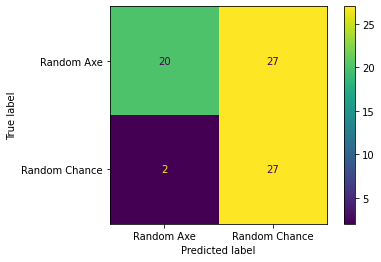

In [20]:
# Get the predictions

predictions = make_predictions(model = fitted_model, X_test = X_test)


ytrue =Labels_test
ypredict = predictions

cm = confusion_matrix(ytrue, ypredict)    
disp = ConfusionMatrixDisplay(cm, display_labels=['Random Axe', 'Random Chance'])
disp.plot()


# convert to numerics to get scores


ytrue_n = []
ypredict_n = []


for i in ytrue:
    if i == 'Random Axe':
        ytrue_n.append(1)
    else:
        ytrue_n.append(0)
        
for i in ypredict:
    if i == 'Random Axe':
        ypredict_n.append(1)
    else:
        ypredict_n.append(0)


        
        
print(f'The accuracy of the model is: {round(accuracy_score(ytrue_n, ypredict_n), 3)}')        
print(f'The f1-score of the model is: {round(f1_score(ytrue_n, ypredict_n), 3)}')
print(f'The precision of the model is: {round(precision_score(ytrue_n, ypredict_n), 3)}')
print(f'The recall of the model is: {round(recall_score(ytrue_n, ypredict_n), 3)}')